In [274]:
import glob
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
from iberoSignalPro import imagen as bim

In [275]:

stack = []
for f in glob.glob(r"E:\FernandoMoralesHernandez\13-01-21\DICOM\ST000000\SE000001\*"):
    #print(f"Cargando: {f}")
    ds = pydicom.dcmread(f)
    pix = ds.pixel_array
    #pix = pix + (-1024)
    stack.append(pix)

original_stack = np.dstack(stack)
original_stack = np.array(original_stack)

In [276]:
cut_size = 140
y = original_stack.copy()
y = y[(y.shape[0]//2) - cut_size: (y.shape[0]//2) + cut_size, (y.shape[1]//2) - cut_size: (y.shape[1]//2) + cut_size, 21:]
y = y.swapaxes(0, 2)
y = y.swapaxes(1, 2)

y.shape


(138, 280, 280)

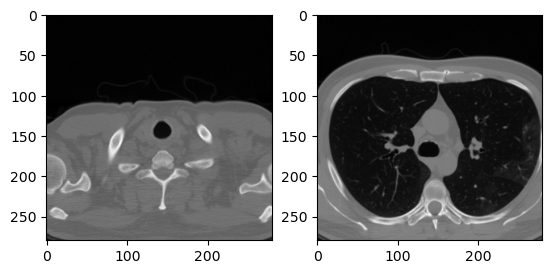

In [277]:
first_cut = y[0, :, :]
lung_cut = y[40,:, :]
bim.show_two_normalized(first_cut, lung_cut)

In [278]:
from scipy.ndimage import binary_fill_holes

In [ ]:
for i, lena in enumerate(y):
    temp_img = y[i, :, :]
    temp_img = bim.normalize_image(temp_img)
    temp_img = bim.equalize_image(temp_img, 0.3, 0.8)
    temp_img = bim.normalize_image(temp_img)

    Gauss = bim.Gauss(3, 0, 5)
    temp_img = bim.conv2d(temp_img, Gauss)

    mask = bim.thresh_mask(temp_img, 0.1, 1)
    
    kernel = np.array(bim.KernelCirc(3), dtype=np.float32)
    kernel = (kernel * 255).round().astype(np.uint8)

    iter = 2
    img_erosion = cv2.erode(mask, kernel, iterations=iter)
    #img_dilation = cv2.dilate(img_erosion, kernel, iterations=iter)

    img_dilation = bim.normalize_image(img_erosion)
    img_dilation = bim.normalize_image(img_erosion)

    temp_img = abs(img_dilation)



    y[i, :, :] = temp_img  * 255

y = y/255

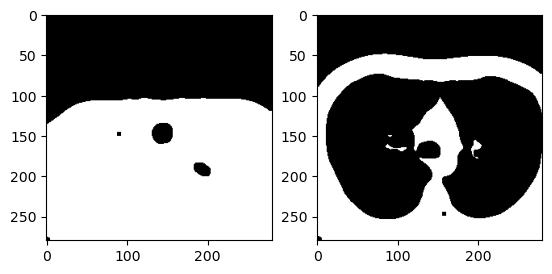

In [280]:

first_cut = y[3, :, :]
lung_cut = y[40,:, :]
bim.show_two_normalized(first_cut, lung_cut)

In [281]:
from stl import mesh
import pandas as pd

from skimage import measure

In [282]:
def array_to_stl_marching_cubes(array_3d, filename):
    """
    Convierte un arreglo 3D a un archivo STL utilizando el algoritmo de Marching Cubes.
    
    :param array_3d: Un arreglo 3D de NumPy donde los valores de 1 representan objetos sólidos y los valores de 0 representan vacío.
    :param filename: El nombre del archivo STL a crear.
    """
    # Aplicar el algoritmo de Marching Cubes para obtener la malla
    verts, faces, _, _ = measure.marching_cubes(array_3d, level=0.1)
    
    # Crear la malla
    mesh_data = mesh.Mesh(np.zeros(faces.shape[0], dtype=mesh.Mesh.dtype))
    
    for i, face in enumerate(faces):
        for j in range(3):
            mesh_data.vectors[i][j] = verts[face[j], :]
    
    # Guardar el archivo STL
    mesh_data.save(filename)


In [284]:
array_to_stl_marching_cubes(y, 'solido2.stl')

In [285]:
from stl import mesh
from mpl_toolkits import mplot3d
from matplotlib import pyplot


In [286]:
%matplotlib inline

In [287]:

def explain3D_histogram(stack, plothistogram = False, plotcumsums= False):
    xbins = np.linspace(0, 1, 256)
    
    histograms = []
    cumsums = []
    
    for lena in stack:
        xx, bins = np.histogram(lena.ravel(), bins=xbins)
        histograms.append(xx)  
        cumsums.append(np.cumsum(xx)) 
    histograms = np.array(histograms)
    cumsums = np.array(cumsums)

    if plothistogram:
        x = bins[1:] 
        y_indices = np.arange(len(histograms))

        # Datos para las barras
        bar_x = []
        bar_y = []
        bar_z = []
        dx = []
        dy = []
        dz = []

        for yi, hist in zip(y_indices, histograms):
            for xi, value in zip(x, hist[1:]):
                bar_x.append(xi)
                bar_y.append(yi)
                bar_z.append(0)
                dx.append((x[1] - x[0]))  # ancho de bin
                dy.append(1.5)  # espacio entre imágenes
                dz.append(value)

        # Crear figura y ejes 3D
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection='3d')

        # Dibujar barras 3D
        ax.bar3d(
            bar_x, bar_y, bar_z,
            dx, dy, dz,
            shade=True,
            color='gray',
            alpha=0.6
        )

        ax.set_xlabel('Pixel Intensity')
        ax.set_ylabel('Image Index')
        ax.set_zlabel('Counts')
        ax.set_title('3D Histogram of Stack')

        plt.show()

    if plotcumsums:
        x = bins[1:] 
        y_indices = np.arange(len(histograms))
        fig2 = plt.figure(figsize=(12, 8))
        ax2 = fig2.add_subplot(111, projection='3d')

        for yi, cumsum in zip(y_indices, cumsums):
            ax2.plot(
                x,                   # pixel intensity (x)
                [yi]*len(cumsum),     # y fijo para cada imagen
                cumsum,               # cumsum values (z)
            )

        ax2.set_xlabel('Pixel Intensity')
        ax2.set_ylabel('Image Index')
        ax2.set_zlabel('Cumulative Sum')
        ax2.set_title('3D Cumulative Sum Curves')

        plt.show()
    return bins, histograms, cumsums


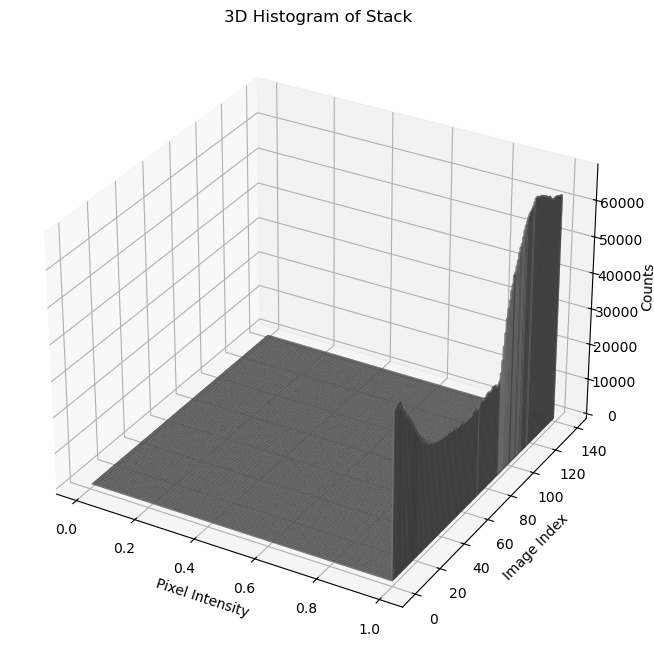

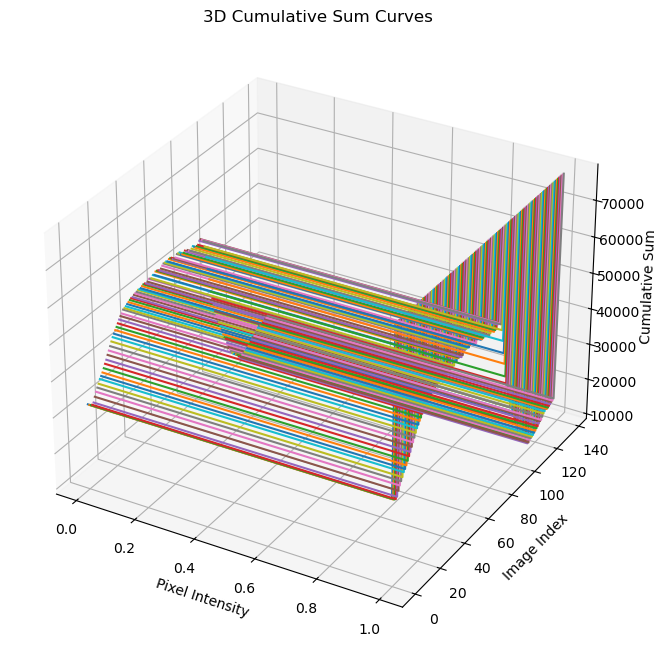

In [288]:
bins, histograms, cumsums = explain3D_histogram(stack=y, plothistogram = True, plotcumsums= True)

In [289]:
histograms.shape

(138, 255)

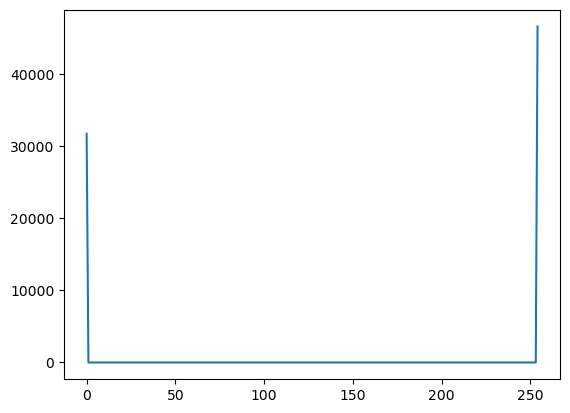

In [290]:
plt.plot(histograms[4, :])